In [346]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report, roc_curve, auc
from imblearn.over_sampling import SMOTE

In [347]:
df = pd.read_csv("UCI_Credit_Card.csv")
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


Basic Data Analyses

In [348]:
df.shape

(30000, 25)

In [349]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [350]:
df.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

In [351]:
df.duplicated().sum()

np.int64(0)

Exploratory Data Analyses - EDA

In [352]:
df = df.drop(columns=['ID'])

In [353]:
df.rename(columns={'default.payment.next.month': 'default'}, inplace=True)

In [354]:
print(df['EDUCATION'].value_counts(),"\n")

print(df['MARRIAGE'].value_counts(),"\n")

print(df['AGE'].value_counts())

EDUCATION
2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: count, dtype: int64 

MARRIAGE
2    15964
1    13659
3      323
0       54
Name: count, dtype: int64 

AGE
29    1605
27    1477
28    1409
30    1395
26    1256
31    1217
25    1186
34    1162
32    1158
33    1146
24    1127
35    1113
36    1108
37    1041
39     954
38     944
23     931
40     870
41     824
42     794
44     700
43     670
45     617
46     570
22     560
47     501
48     466
49     452
50     411
51     340
53     325
52     304
54     247
55     209
56     178
57     122
58     122
59      83
21      67
60      67
61      56
62      44
64      31
63      31
66      25
65      24
67      16
69      15
70      10
68       5
73       4
75       3
71       3
72       3
79       1
74       1
Name: count, dtype: int64


In [355]:
df['EDUCATION'] = df['EDUCATION'].replace([0, 5, 6], 4)

df['MARRIAGE'] = df['MARRIAGE'].replace([0], 3)

print(df['EDUCATION'].value_counts(),"\n")
print(df['MARRIAGE'].value_counts())

EDUCATION
2    14030
1    10585
3     4917
4      468
Name: count, dtype: int64 

MARRIAGE
2    15964
1    13659
3      377
Name: count, dtype: int64


default
0    23364
1     6636
Name: count, dtype: int64


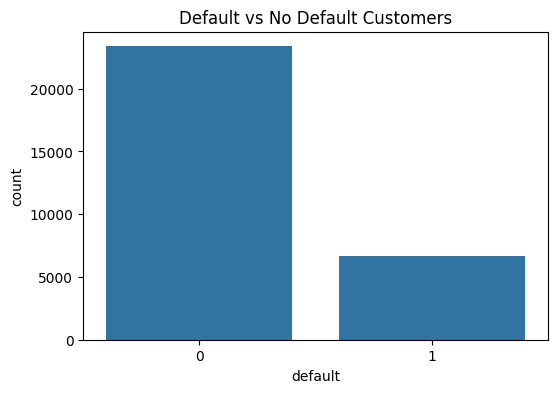

In [356]:
print(df['default'].value_counts())

plt.figure(figsize=(6,4))
sns.countplot(x='default', data=df)
plt.title("Default vs No Default Customers")
plt.show()

In [357]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

outlier_summary = {}
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_summary[col] = len(outliers)
print("Outlier Count per Column (IQR Method):")
for key, val in outlier_summary.items():
    print(f"{key}  :  {val} outliers")

Outlier Count per Column (IQR Method):
LIMIT_BAL  :  167 outliers
SEX  :  0 outliers
EDUCATION  :  468 outliers
MARRIAGE  :  0 outliers
AGE  :  272 outliers
PAY_0  :  3130 outliers
PAY_2  :  4410 outliers
PAY_3  :  4209 outliers
PAY_4  :  3508 outliers
PAY_5  :  2968 outliers
PAY_6  :  3079 outliers
BILL_AMT1  :  2400 outliers
BILL_AMT2  :  2395 outliers
BILL_AMT3  :  2469 outliers
BILL_AMT4  :  2622 outliers
BILL_AMT5  :  2725 outliers
BILL_AMT6  :  2693 outliers
PAY_AMT1  :  2745 outliers
PAY_AMT2  :  2714 outliers
PAY_AMT3  :  2598 outliers
PAY_AMT4  :  2994 outliers
PAY_AMT5  :  2945 outliers
PAY_AMT6  :  2958 outliers
default  :  6636 outliers


In [358]:
num_cols = ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

for col in num_cols:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df[col] = np.clip(df[col], lower, upper)
    
print("Outlier Count per Column after Clipping:")
for col in num_cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col].count()
    print(f"{col} : {outliers} outliers")

Outlier Count per Column after Clipping:
LIMIT_BAL : 0 outliers
AGE : 0 outliers
PAY_0 : 3130 outliers
PAY_2 : 4410 outliers
PAY_3 : 4209 outliers
PAY_4 : 3508 outliers
PAY_5 : 2968 outliers
PAY_6 : 3079 outliers
BILL_AMT1 : 2398 outliers
BILL_AMT2 : 2395 outliers
BILL_AMT3 : 2468 outliers
BILL_AMT4 : 2620 outliers
BILL_AMT5 : 2724 outliers
BILL_AMT6 : 2688 outliers
PAY_AMT1 : 2745 outliers
PAY_AMT2 : 2714 outliers
PAY_AMT3 : 2598 outliers
PAY_AMT4 : 2994 outliers
PAY_AMT5 : 2945 outliers
PAY_AMT6 : 2958 outliers


In [359]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('default')

skew_values = df[num_cols].skew().sort_values(ascending=False)
print("Skewness of Numerical Features:\n", skew_values)

Skewness of Numerical Features:
 PAY_AMT6     5.223211
PAY_AMT2     4.882634
PAY_AMT3     4.799828
PAY_AMT4     4.790998
PAY_AMT5     4.781006
PAY_AMT1     4.481036
BILL_AMT4    2.224446
BILL_AMT5    2.215094
BILL_AMT6    2.214609
BILL_AMT3    2.188063
BILL_AMT2    2.159753
BILL_AMT1    2.154584
LIMIT_BAL    0.890065
AGE          0.649240
PAY_2        0.542669
PAY_3        0.514636
PAY_4        0.499901
EDUCATION    0.489720
PAY_6        0.486031
PAY_5        0.481898
PAY_0        0.329110
MARRIAGE     0.036154
SEX         -0.424183
dtype: float64


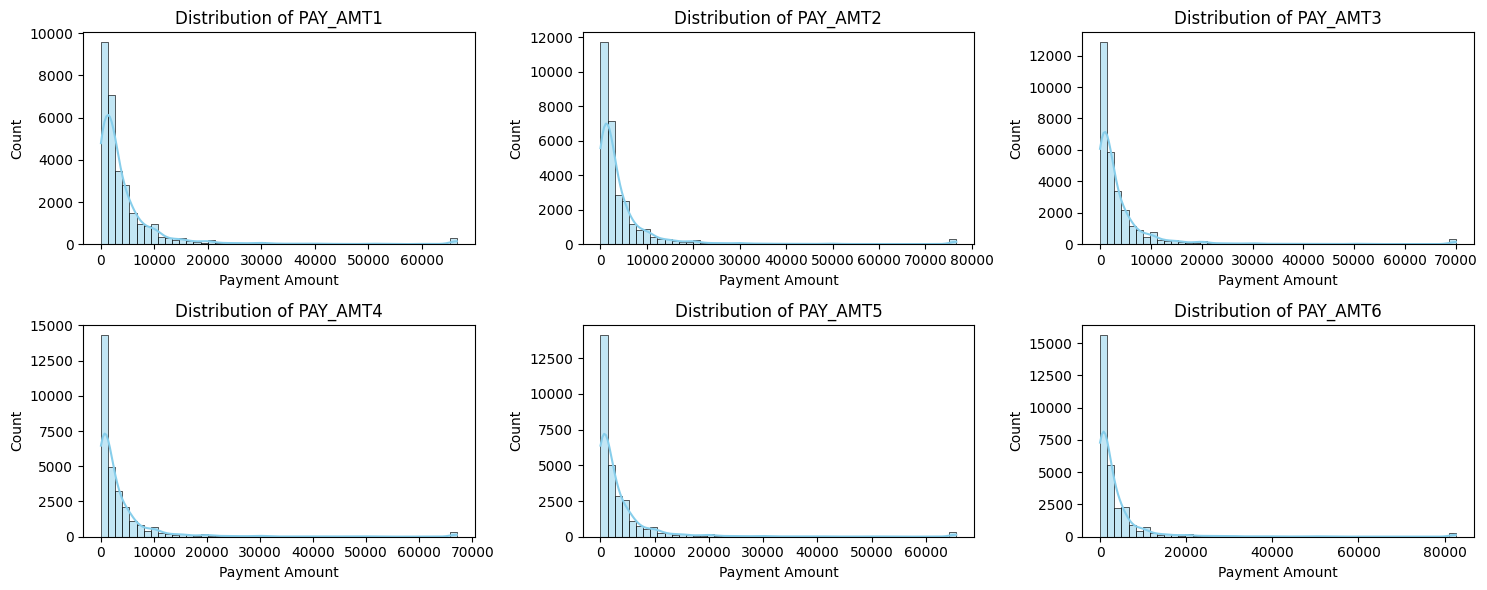

In [360]:
pay_amt_cols = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']

fig, axes = plt.subplots(2, 3, figsize=(15, 6))
axes = axes.flatten()
for i, col in enumerate(pay_amt_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color='skyblue', bins=50)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('Payment Amount')
    axes[i].set_ylabel('Count')
plt.tight_layout()
plt.show()

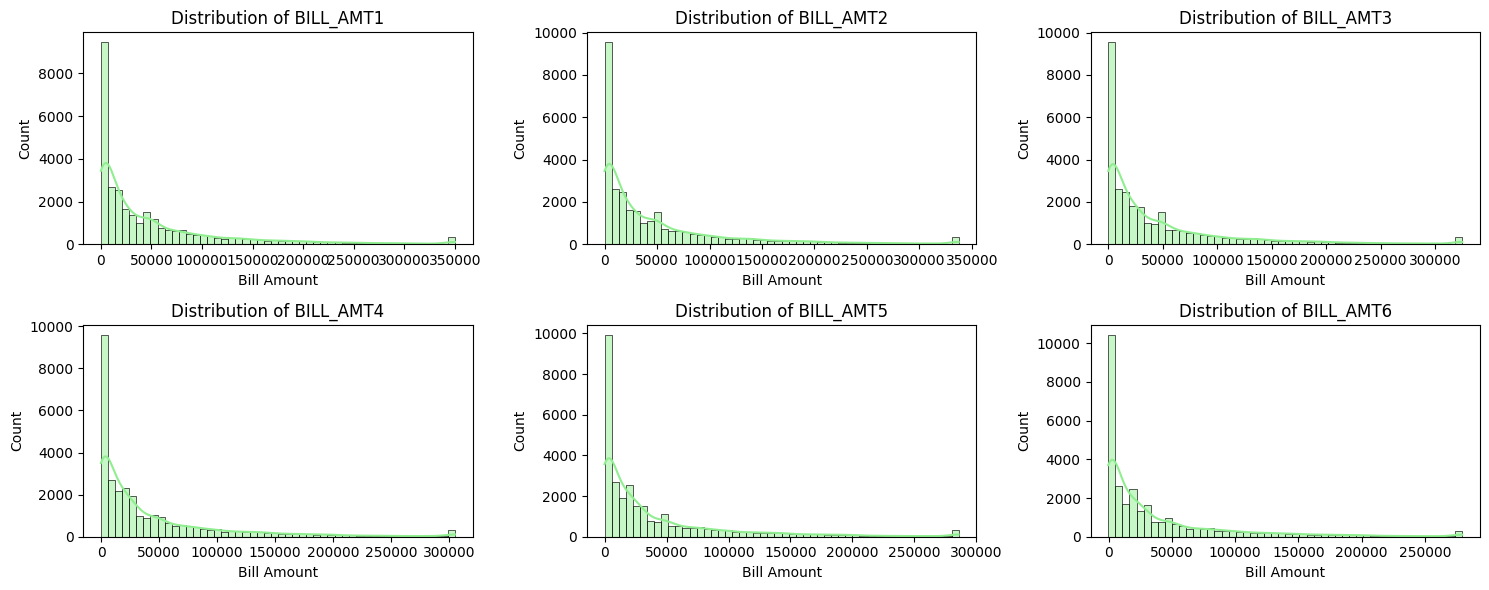

In [361]:
bill_amt_cols = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

fig, axes = plt.subplots(2, 3, figsize=(15, 6))
axes = axes.flatten()
for i, col in enumerate(bill_amt_cols):
    sns.histplot(df[col], kde=True, ax=axes[i], color='lightgreen', bins=50)
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel('Bill Amount')
    axes[i].set_ylabel('Count')
plt.tight_layout()
plt.show()

In [362]:
skewed_cols = ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6']

for col in skewed_cols:
    df[col] = df[col].clip(lower=0)
    df[col] = np.log1p(df[col])
    print(f"Skewness of {col}: {df[col].skew():.3f}")

Skewness of PAY_AMT1: -1.309
Skewness of PAY_AMT2: -1.258
Skewness of PAY_AMT3: -1.095
Skewness of PAY_AMT4: -0.981
Skewness of PAY_AMT5: -0.953
Skewness of PAY_AMT6: -0.868
Skewness of BILL_AMT1: -1.725
Skewness of BILL_AMT2: -1.607
Skewness of BILL_AMT3: -1.543
Skewness of BILL_AMT4: -1.484
Skewness of BILL_AMT5: -1.402
Skewness of BILL_AMT6: -1.281


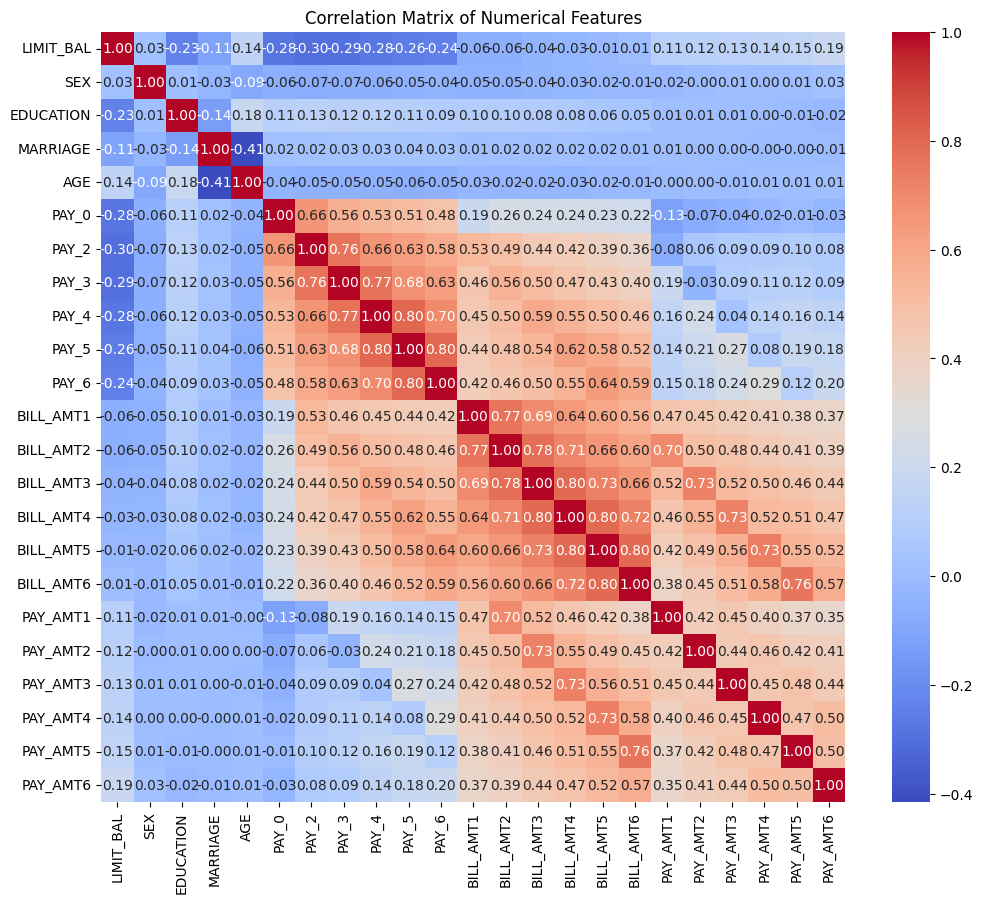

Correlation with target:
 default      1.000000
PAY_0        0.328366
PAY_2        0.264478
PAY_3        0.233753
PAY_4        0.213136
PAY_5        0.199674
PAY_6        0.182026
EDUCATION    0.033842
AGE          0.013647
BILL_AMT6   -0.004983
BILL_AMT4   -0.010495
BILL_AMT3   -0.011165
BILL_AMT2   -0.012887
BILL_AMT5   -0.013236
BILL_AMT1   -0.024553
MARRIAGE    -0.027575
SEX         -0.039961
PAY_AMT5    -0.109760
PAY_AMT6    -0.111303
PAY_AMT4    -0.125935
PAY_AMT3    -0.139190
PAY_AMT2    -0.149871
LIMIT_BAL   -0.154572
PAY_AMT1    -0.170134
Name: default, dtype: float64


In [363]:
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('default')

corr_matrix = df[num_cols].corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

target_corr = df.corr()['default'].sort_values(ascending=False)
print("Correlation with target:\n", target_corr)

Features and target

In [364]:
X = df.drop('default', axis=1)
y = df['default']

Train-test split

In [365]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [366]:
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (24000, 23)
Test shape: (6000, 23)


Handle Class Imbalance — SMOTE

In [367]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

Define Base Estimator & AdaBoost

In [368]:
base_est = DecisionTreeClassifier(max_depth=3, random_state=42)
ada = AdaBoostClassifier(estimator=base_est, n_estimators=100, learning_rate=0.5, random_state=42)

In [369]:
param_grid = {
    'n_estimators': [100, 150, 200, 500],
    'learning_rate': [0.01, 0.1, 0.5, 1.0]
}

grid_search = GridSearchCV(ada, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


,estimator,AdaBoostClass...ndom_state=42)
,param_grid,"{'learning_rate': [0.01, 0.1, ...], 'n_estimators': [100, 150, ...]}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [370]:
best_ada = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'learning_rate': 0.1, 'n_estimators': 500}


In [371]:
y_pred = best_ada.predict(X_test)
y_proba = best_ada.predict_proba(X_test)[:, 1]

Evaluate on Test Set

In [372]:
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
roc_auc = auc(*roc_curve(y_test, y_proba)[:2])

print(f"\nAccuracy: {acc:.3f}")
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc:.3f}")


Accuracy: 0.817

Confusion Matrix:
 [[4431  242]
 [ 858  469]]

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89      4673
           1       0.66      0.35      0.46      1327

    accuracy                           0.82      6000
   macro avg       0.75      0.65      0.67      6000
weighted avg       0.80      0.82      0.79      6000

ROC-AUC Score: 0.779


ROC Curve Visualization

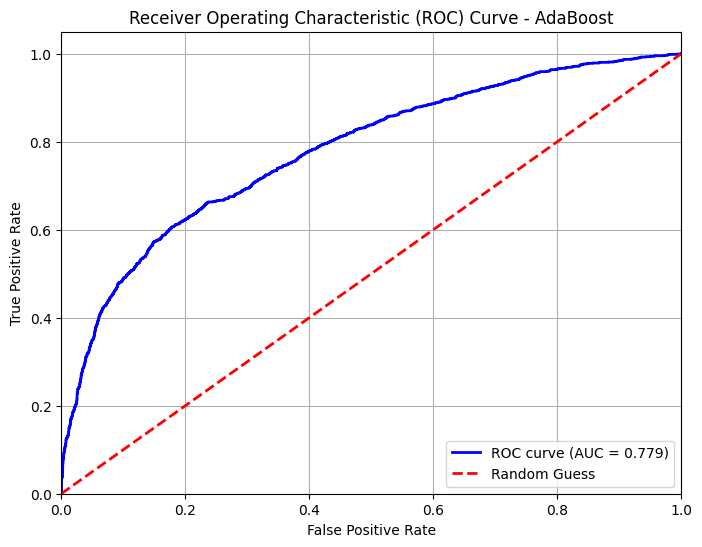

In [373]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("Receiver Operating Characteristic (ROC) Curve - AdaBoost")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Save Model

In [374]:
import pickle

with open('credit_default_model.pkl', 'wb') as f:
    pickle.dump(ada, f)

print("Model saved successfully as credit_default_model.pkl")

Model saved successfully as credit_default_model.pkl
